In [44]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

path = str(Path(Path('thermo.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import scipy
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from tools.cbook import pickle2Obj
import tools
from tools.FV3_tools import read_solo_fields

import matplotlib.colors as mcolors

cmap_data = [(1.0, 1.0, 1.0),
         (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
         (0.0, 1.0, 1.0),
         (0.0, 0.8784313797950745, 0.501960813999176),
         (0.0, 0.7529411911964417, 0.0),
         (0.501960813999176, 0.8784313797950745, 0.0),
         (1.0, 1.0, 0.0),
         (1.0, 0.6274510025978088, 0.0),
         (1.0, 0.0, 0.0),
         (1.0, 0.125490203499794, 0.501960813999176),
         (0.9411764740943909, 0.250980406999588, 1.0),
         (0.501960813999176, 0.125490203499794, 1.0),
         (0.250980406999588, 0.250980406999588, 1.0),
         (0.125490203499794, 0.125490203499794, 0.501960813999176),
         (0.125490203499794, 0.125490203499794, 0.125490203499794),
         (0.501960813999176, 0.501960813999176, 0.501960813999176),
         (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
         (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
         (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
         (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
         (0.4000000059604645, 0.20000000298023224, 0.0)]

_nthreads = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
paths = {}
paths['solo_hdd125'] = '/work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd125_C2000_00'
paths['solo_hdd012'] = '/work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd012_C2000_00'
paths['solo_hdd001'] = '/work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd001_C2000_00'


In [46]:
ds, dims = read_solo_fields(paths['solo_hdd125'] , vars = [''], file_pattern=None, ret_dbz=False, ret_ds=True)
ds2,dims2      = read_solo_fields(paths['solo_hdd012'] , vars = [''], file_pattern=None, ret_dbz=False, ret_ds=True)
ds3,dims3     = read_solo_fields(paths['solo_hdd001'] , vars = [''], file_pattern=None, ret_dbz=False, ret_ds=True)

------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd125_C2000_00/atmos_hifreq.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd125_C2000_00/atmos_hifreq.nc 

 Completed reading in:  /work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd125_C2000_00/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd012_C2000_00/atmos_hifreq.nc
-------------------------------------------------------------------------------------------

In [104]:
#---------------------------------------------------------------------
# local interp function
def interp3dz_np(data, z3d, z1d, nthreads = _nthreads):

    # dinterp = np.zeros((len(z1d),),dtype=np.float32)

    # # for j in np.arange(data.shape[1]):
    # dinterp[:] = np.interp1d(z1d, z3d[:], data[:])

    f_linear = scipy.interpolate.interp1d(z3d,data) 

    return f_linear(z1d)

def wplot(time, z, w, ax=None):

    zhgts = (100. + 100.*np.arange(200))/1000.
    
    if ax == None:
        fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(5,5))

    winterp = np.zeros((time.shape[0],len(zhgts)),dtype=np.float32)
    
    for n in np.arange(time.shape[0]):
        winterp[n] = interp3dz_np(w[n], z[n], zhgts, nthreads = -2)

    print(winterp.shape, zhgts.shape, time.shape)

    ax.contourf(time, zhgts, winterp.transpose(), clevs, cmap=plt.cm.viridis_r)
    ax.contour(time, zhgts, winterp.transpose(), [5,15,25,35,45], colors='k', alpha=0.5)
     ax.contour(time, zhgts, winterp.transpose(), [-10,-5], colors='b', alpha=0.5)
    
    ax.set_xlabel('Time (min)', fontsize=12)
    ax.set_ylabel('Z (km)', fontsize=12)

    ax.axhline(y=15.)
    
    ax.set_title("Time/Height for W  Max: %f  Min: %f" % (winterp.max(), winterp.min()), fontsize=12)


IndentationError: unexpected indent (401098646.py, line 30)

(24, 200) (200,) (24,)
(24, 200) (200,) (24,)
(24, 200) (200,) (24,)


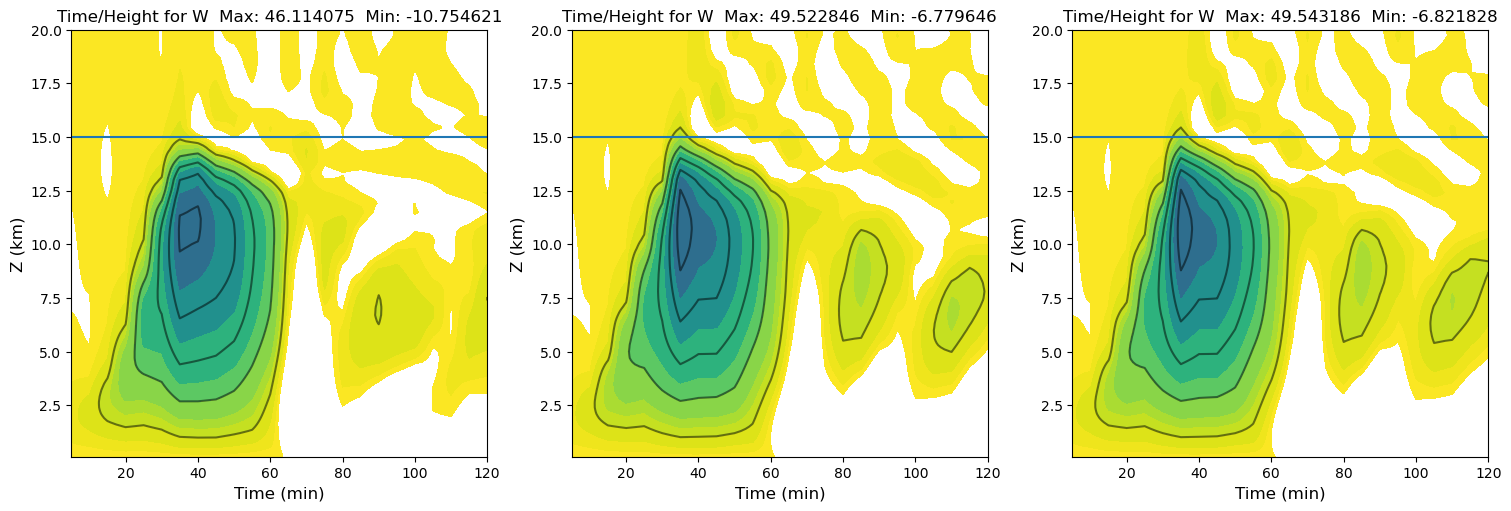

In [105]:
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 70]

fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))

#
time1 = dims['time']/60.
time = np.tile(time1, (60,1)).transpose()

#

z3d    = dims.delz.values[:,::-1,:,:]
z3d    = np.cumsum(z3d,axis=1)

w_col = ds['w'][:,:,40,40]
z_col = z3d[:,:,40,40] * 0.001
wplot(time1, z_col, w_col, ax=ax[0])

#
w_col2 = ds2['w'][:,:,40,40]
z3d    = dims2.delz.values[:,::-1,:,:]
z3d    = np.cumsum(z3d,axis=1)
z_col2  = z3d[:,:,40,40] * 0.001
wplot(time1, z_col2, w_col2, ax=ax[1])

z3d    = dims3.delz.values[:,::-1,:,:]
z3d    = np.cumsum(z3d,axis=1)
z_col3 = z3d[:,:,40,40] * 0.001
w_col3 = ds3['w'][:,:,40,40]

wplot(time1, z_col3, w_col3, ax=ax[2])


In [101]:
from scipy.stats import gaussian_kde

def kde_plotter(mdata, mlabel, mcolor, ax=None):

    xlim = [-15,55]
    
    if ax == None:
        fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(7,7))

    for data, label, color in zip(mdata,mlabel,mcolor):
        print(label, color)
        
        hist, bin_edges = np.histogram(data.flatten())

        data_no_zero = data.flatten()
    
        eval_points = np.linspace(np.min(bin_edges), np.max(bin_edges))
        kde_sp      = gaussian_kde(data_no_zero, bw_method=0.9)
        y_sp        = kde_sp.pdf(eval_points)
        
        ax.plot(eval_points, y_sp, color=color, linewidth=2.0, label='%s  %d' % (label,data_no_zero.shape[0]))
             
    ax.set_xlim(xlim[:])
    ax.set_yscale("log")
#    ax.set_xscale("log", base=2.0)
    plt.grid(axis='y', alpha=0.75)
    plt.grid(axis='x', alpha=0.75)
    ax.set_xlabel('mm',fontsize=15)
    ax.set_ylabel('Density',fontsize=15)
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    ax.axvline(x=40.0, color='k', linestyle='--', linewidth=2.0)
    ax.axvline(x=80.0, color='k', linestyle='--', linewidth=2.0)
    ax.set_title('W' , fontsize=15)


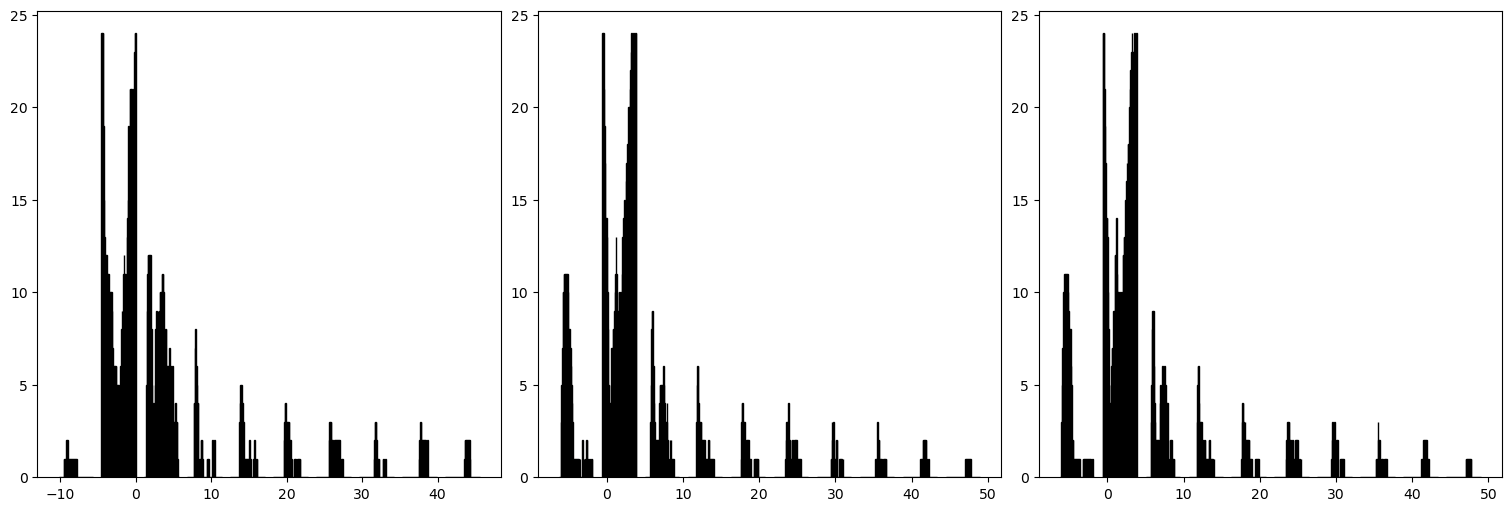

In [102]:
fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))
ax[0].hist(w_col, bins=10, edgecolor='black')
ax[1].hist(w_col2, bins=10, edgecolor='black')
ax[2].hist(w_col3, bins=10, edgecolor='black')
plt.show()

hdd125 k
hdd012 r
hdd001 b


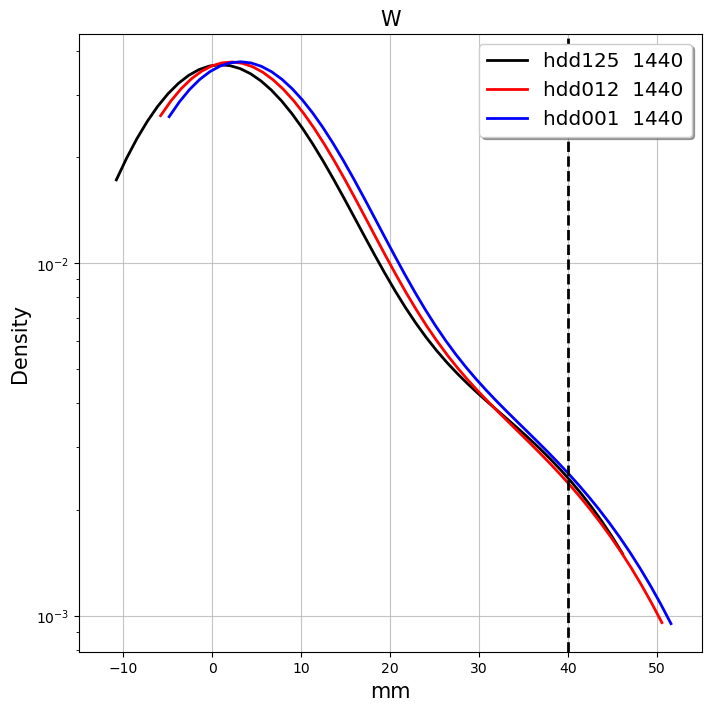

In [103]:
kde_plotter([w_col,w_col2+1.0,w_col3+2.0], ['hdd125','hdd012','hdd001'], ['k','r','b'])
    
plt.show()